In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from core.multi_asset_loader import load_assets
from core.portfolio.portfolio_manager_v2 import PortfolioManagerV2
from core.benchmark import BenchmarkLoader, BenchmarkComparator

# Import all signal types
from signals.momentum import MomentumSignalV2
from signals.mean_reversion import MeanReversionSignal
from signals.trend_following_long_short import TrendFollowingLongShort, AdaptiveTrendFollowing
from signals.ensemble import AdaptiveEnsemble

# Import new plotting and formatting utilities
from utils.plotter import PortfolioPlotter
from utils.formatter import PerformanceSummary, compare_periods

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Setup complete - Using refactored plotting utilities")

✅ Setup complete - Using refactored plotting utilities


## 1. Load Multi-Asset Data

Load futures data: ES, GC, NQ (10 years of data)

In [2]:
print("📊 Loading multi-asset data...")
prices = load_assets(
    tickers=['ES', 'GC', 'NQ'],
    start_date='2015-01-01',
    end_date='2024-12-31'
)

print(f"\n✅ Data loaded:")
for ticker, df in prices.items():
    print(f"   {ticker}: {len(df)} days ({df.index[0].date()} to {df.index[-1].date()})")
    print(f"      Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")

📊 Loading multi-asset data...

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 334 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-28)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-28
  📡 CSV data is 334 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-28)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-28
  📡 CSV data is 334 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-28)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-28
  📡 CSV data is 334 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-28)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-28
  📡 CSV data is 334 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-28)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-28

Common date range: 2000-09-18 to 2025-11-28
Filtered date range: 2015-01-01 to 2024-12-31



## 2. Configure Multi-Strategy Portfolio with New Signals

**Strategy 1: Adaptive Ensemble on ES + GC**
- Combines Momentum + Trend Following Long-Short
- Dynamic weighting based on performance
- Trades both ES and GC futures

**Strategy 2: Trend Following Long-Short on NQ**
- Pure trend signal with volume/volatility filters
- Can go long, short, or flat
- Trades only NQ

**Strategy 3: Classic Momentum on ES (Baseline)**
- Simple momentum for comparison
- Trades only ES

In [3]:
# Define strategies with NEW signals
strategies = [
    {
        'name': 'Adaptive_Ensemble',
        'signal_generator': AdaptiveEnsemble(
            strategies=[
                ('momentum', MomentumSignalV2(lookback=60, entry_threshold=0.02), 0.33),
                ('trend_ls', TrendFollowingLongShort(fast_period=20, slow_period=100), 0.34),
                ("adaptive_trend", AdaptiveTrendFollowing(base_period=60, atr_period=14, vol_lookback=120, base_threshold=0.03), 0.33)
            ],
            method='adaptive',
            adaptive_lookback=60,
            signal_threshold=0.3,
            rebalance_frequency=20
        ),
        'assets': ['ES', 'GC'],  # Apply ensemble to both ES and GC
        'capital': 33000
    },
    {
        'name': 'TrendFollowing_LS',
        'signal_generator': TrendFollowingLongShort(
            fast_period=20,
            slow_period=100,
            momentum_threshold=0.02,
            volume_multiplier=1.4,
            vol_percentile=0.85
        ),
        'assets': ['NQ', 'GC'],  # Long-short on NQ
        'capital': 34000
    },
    {
        'name': 'Classic_Momentum',
        'signal_generator': MomentumSignalV2(
            lookback=60,
            entry_threshold=0.025,
            exit_threshold=-0.015
        ),
        'assets': ['NQ','GC'],  # Baseline momentum on ES
        'capital': 33000
    }
]

total_capital = sum(s['capital'] for s in strategies)

print("✅ Configured Strategies:")
for i, strat in enumerate(strategies, 1):
    assets_str = ', '.join(strat['assets'])
    signal_type = strat['signal_generator'].__class__.__name__
    print(f"{i}. {strat['name']}")
    print(f"   Signal Type: {signal_type}")
    print(f"   Capital: ${strat['capital']:,}")
    print(f"   Assets: {assets_str}")
    print()

print(f"Total Portfolio Capital: ${total_capital:,}")

✅ Configured Strategies:
1. Adaptive_Ensemble
   Signal Type: AdaptiveEnsemble
   Capital: $33,000
   Assets: ES, GC

2. TrendFollowing_LS
   Signal Type: TrendFollowingLongShort
   Capital: $34,000
   Assets: NQ, GC

3. Classic_Momentum
   Signal Type: MomentumSignalV2
   Capital: $33,000
   Assets: NQ, GC

Total Portfolio Capital: $100,000


## 3. Generate Signals for All Strategies

Each strategy generates signals for its assigned assets.

**Key Point:** AdaptiveEnsemble works on **one dataset at a time**. When we assign it to ['ES', 'GC'], it will:
1. Generate ensemble signal for ES
2. Generate ensemble signal for GC (separately)

This is the same pattern as the old approach - one signal generator per asset.

In [4]:
# Generate signals for all strategies
signals = {}

for strat in strategies:
    name = strat['name']
    signal_generator = strat['signal_generator']
    assets = strat['assets']
    
    print(f"\n🎯 {name} ({signal_generator.__class__.__name__}):")
    
    # Generate signals for each asset this strategy trades
    strategy_signals = {}
    for asset in assets:
        if asset not in prices:
            print(f"  ⚠️  Warning: {asset} not found in loaded data!")
            continue
        
        # Generate signal for this asset
        print(f"  Generating signals for {asset}...")
        sig = signal_generator.generate(prices[asset].copy())
        strategy_signals[asset] = sig
        
        # Display signal summary
        total_signals = sig['Signal'].abs().sum()
        long_signals = (sig['Signal'] == 1).sum()
        short_signals = (sig['Signal'] == -1).sum()
        flat_signals = (sig['Signal'] == 0).sum()
        
        print(f"    {asset}: {long_signals} longs ({long_signals/len(sig)*100:.1f}%), "
              f"{short_signals} shorts ({short_signals/len(sig)*100:.1f}%), "
              f"{flat_signals} flat ({flat_signals/len(sig)*100:.1f}%)")
        
        # For ensemble, show component weights if available
        if isinstance(signal_generator, AdaptiveEnsemble):
            if 'momentum_Weight' in sig.columns:
                final_mom_weight = sig['momentum_Weight'].iloc[-1]
                final_tf_weight = sig['trend_ls_Weight'].iloc[-1]
                print(f"    Latest Weights - Momentum: {final_mom_weight:.1%}, TrendLS: {final_tf_weight:.1%}")
    
    signals[name] = strategy_signals

print(f"\n✅ Generated signals for {len(signals)} strategies across {sum(len(s) for s in signals.values())} assets")


🎯 Adaptive_Ensemble (AdaptiveEnsemble):
  Generating signals for ES...


    ES: 2330 longs (92.6%), 65 shorts (2.6%), 120 flat (4.8%)
    Latest Weights - Momentum: 42.1%, TrendLS: 15.9%
  Generating signals for GC...
    GC: 1935 longs (76.9%), 440 shorts (17.5%), 140 flat (5.6%)
    Latest Weights - Momentum: 50.0%, TrendLS: 0.0%

🎯 TrendFollowing_LS (TrendFollowingLongShort):
  Generating signals for NQ...
    GC: 1935 longs (76.9%), 440 shorts (17.5%), 140 flat (5.6%)
    Latest Weights - Momentum: 50.0%, TrendLS: 0.0%

🎯 TrendFollowing_LS (TrendFollowingLongShort):
  Generating signals for NQ...
    NQ: 1451 longs (57.7%), 318 shorts (12.6%), 746 flat (29.7%)
  Generating signals for GC...
    GC: 1051 longs (41.8%), 679 shorts (27.0%), 785 flat (31.2%)

🎯 Classic_Momentum (MomentumSignalV2):
  Generating signals for NQ...
    NQ: 2395 longs (95.2%), 0 shorts (0.0%), 120 flat (4.8%)
  Generating signals for GC...
    GC: 2320 longs (92.2%), 0 shorts (0.0%), 195 flat (7.8%)

✅ Generated signals for 3 strategies across 6 assets
    NQ: 1451 longs (57.7%

## 4. Run Backtests for Each Strategy

Run each strategy independently with its allocated capital.

In [5]:
# Run backtests for each strategy
strategy_results = {}

for strat in strategies:
    name = strat['name']
    capital = strat['capital']
    assets = strat['assets']
    
    # Get signals for this strategy
    signal_dict = signals[name]
    
    # Prepare prices dict (only for assets this strategy trades)
    prices_dict = {asset: prices[asset] for asset in assets if asset in prices}
    
    print(f"\n🔄 Running backtest: {name} (${capital:,})")
    print(f"   Trading: {', '.join(assets)}")
    
    # Create portfolio manager for this strategy
    max_pos_size = 1.0 / len(assets) if len(assets) > 1 else 1.0
    
    pm = PortfolioManagerV2(
        initial_capital=capital,
        risk_per_trade=0.02,
        max_position_size=max_pos_size,
        transaction_cost_bps=3.0,
        slippage_bps=2.0
    )
    
    # Run backtest
    result = pm.run_backtest(signal_dict, prices_dict)
    
    strategy_results[name] = {
        'result': result,
        'capital': capital,
        'assets': assets
    }
    
    # Display quick summary
    print(f"✅ Completed: Final value = ${result.final_equity:,.2f}")
    print(f"   Return: {result.metrics['Total Return']:.2%}")
    print(f"   Sharpe: {result.metrics['Sharpe Ratio']:.2f}")
    print(f"   Max DD: {result.metrics['Max Drawdown']:.2%}")
    print(f"   Total Trades: {result.metrics['Total Trades']:.0f}")

print(f"\n✅ All {len(strategy_results)} backtests completed")


🔄 Running backtest: Adaptive_Ensemble ($33,000)
   Trading: ES, GC
✅ Completed: Final value = $78,901.54
   Return: 139.10%
   Sharpe: 0.68
   Max DD: -18.45%
   Total Trades: 0

🔄 Running backtest: TrendFollowing_LS ($34,000)
   Trading: NQ, GC
✅ Completed: Final value = $73,346.72
   Return: 115.73%
   Sharpe: 0.73
   Max DD: -10.32%
   Total Trades: 26

🔄 Running backtest: Classic_Momentum ($33,000)
   Trading: NQ, GC
✅ Completed: Final value = $102,173.31
   Return: 209.62%
   Sharpe: 0.78
   Max DD: -26.18%
   Total Trades: 0

✅ All 3 backtests completed
✅ Completed: Final value = $73,346.72
   Return: 115.73%
   Sharpe: 0.73
   Max DD: -10.32%
   Total Trades: 26

🔄 Running backtest: Classic_Momentum ($33,000)
   Trading: NQ, GC
✅ Completed: Final value = $102,173.31
   Return: 209.62%
   Sharpe: 0.78
   Max DD: -26.18%
   Total Trades: 0

✅ All 3 backtests completed


## 5. Combined Portfolio Analysis

Aggregate all strategies into a single portfolio view.

In [6]:
# Calculate combined portfolio metrics
total_initial = sum(data['capital'] for data in strategy_results.values())

# Get final values
final_values = {
    name: data['result'].final_equity
    for name, data in strategy_results.items()
}
total_final = sum(final_values.values())

# Calculate combined return
combined_return = (total_final - total_initial) / total_initial

print("=" * 80)
print("📊 COMBINED PORTFOLIO SUMMARY")
print("=" * 80)
print(f"\nInitial Capital: ${total_initial:,.2f}")
print(f"Final Value:     ${total_final:,.2f}")
print(f"Total P&L:       ${total_final - total_initial:,.2f}")
print(f"Combined Return: {combined_return:.2%}")

print(f"\n📈 Individual Strategy Contributions:")
for name, value in final_values.items():
    initial = strategy_results[name]['capital']
    pnl = value - initial
    ret = (value - initial) / initial
    weight = initial / total_initial
    print(f"  {name:25s}: ${value:>12,.2f} | P&L: ${pnl:>10,.2f} | Return: {ret:>7.2%} | Weight: {weight:>5.1%}")

📊 COMBINED PORTFOLIO SUMMARY

Initial Capital: $100,000.00
Final Value:     $254,421.57
Total P&L:       $154,421.57
Combined Return: 154.42%

📈 Individual Strategy Contributions:
  Adaptive_Ensemble        : $   78,901.54 | P&L: $ 45,901.54 | Return: 139.10% | Weight: 33.0%
  TrendFollowing_LS        : $   73,346.72 | P&L: $ 39,346.72 | Return: 115.73% | Weight: 34.0%
  Classic_Momentum         : $  102,173.31 | P&L: $ 69,173.31 | Return: 209.62% | Weight: 33.0%


## 6. Strategy Metrics Comparison Table

In [7]:
import pandas as pd

# Compile metrics from all strategies
metrics_data = []

for strategy_name, data in strategy_results.items():
    metrics = data['result'].metrics.copy()
    metrics['Strategy'] = strategy_name
    metrics['Allocation'] = data['capital']
    metrics['Assets'] = ', '.join(data['assets'])
    metrics_data.append(metrics)

# Create comparison dataframe
metrics_df = pd.DataFrame(metrics_data)

# Reorder columns for better readability
col_order = ['Strategy', 'Assets', 'Allocation', 'Total Return', 'Sharpe Ratio', 
             'Max Drawdown', 'Win Rate', 'Total Trades']
metrics_df = metrics_df[col_order]

print("📈 Strategy Metrics Comparison")
print("="*120)
display(metrics_df.style.format({
    'Allocation': '${:,.0f}',
    'Total Return': '{:.2%}',
    'Sharpe Ratio': '{:.2f}',
    'Max Drawdown': '{:.2%}',
    'Win Rate': '{:.2%}',
    'Total Trades': '{:.0f}'
}).background_gradient(subset=['Total Return', 'Sharpe Ratio'], cmap='RdYlGn'))

📈 Strategy Metrics Comparison


,Strategy,Assets,Allocation,Total Return,Sharpe Ratio,Max Drawdown,Win Rate,Total Trades
0,Adaptive_Ensemble,"ES, GC","$33,000",139.10%,0.68,-18.45%,0.00%,0
1,TrendFollowing_LS,"NQ, GC","$34,000",115.73%,0.73,-10.32%,61.54%,26
2,Classic_Momentum,"NQ, GC","$33,000",209.62%,0.78,-26.18%,0.00%,0


## 7. Visualize Equity Curves

Plot individual strategies and combined portfolio.

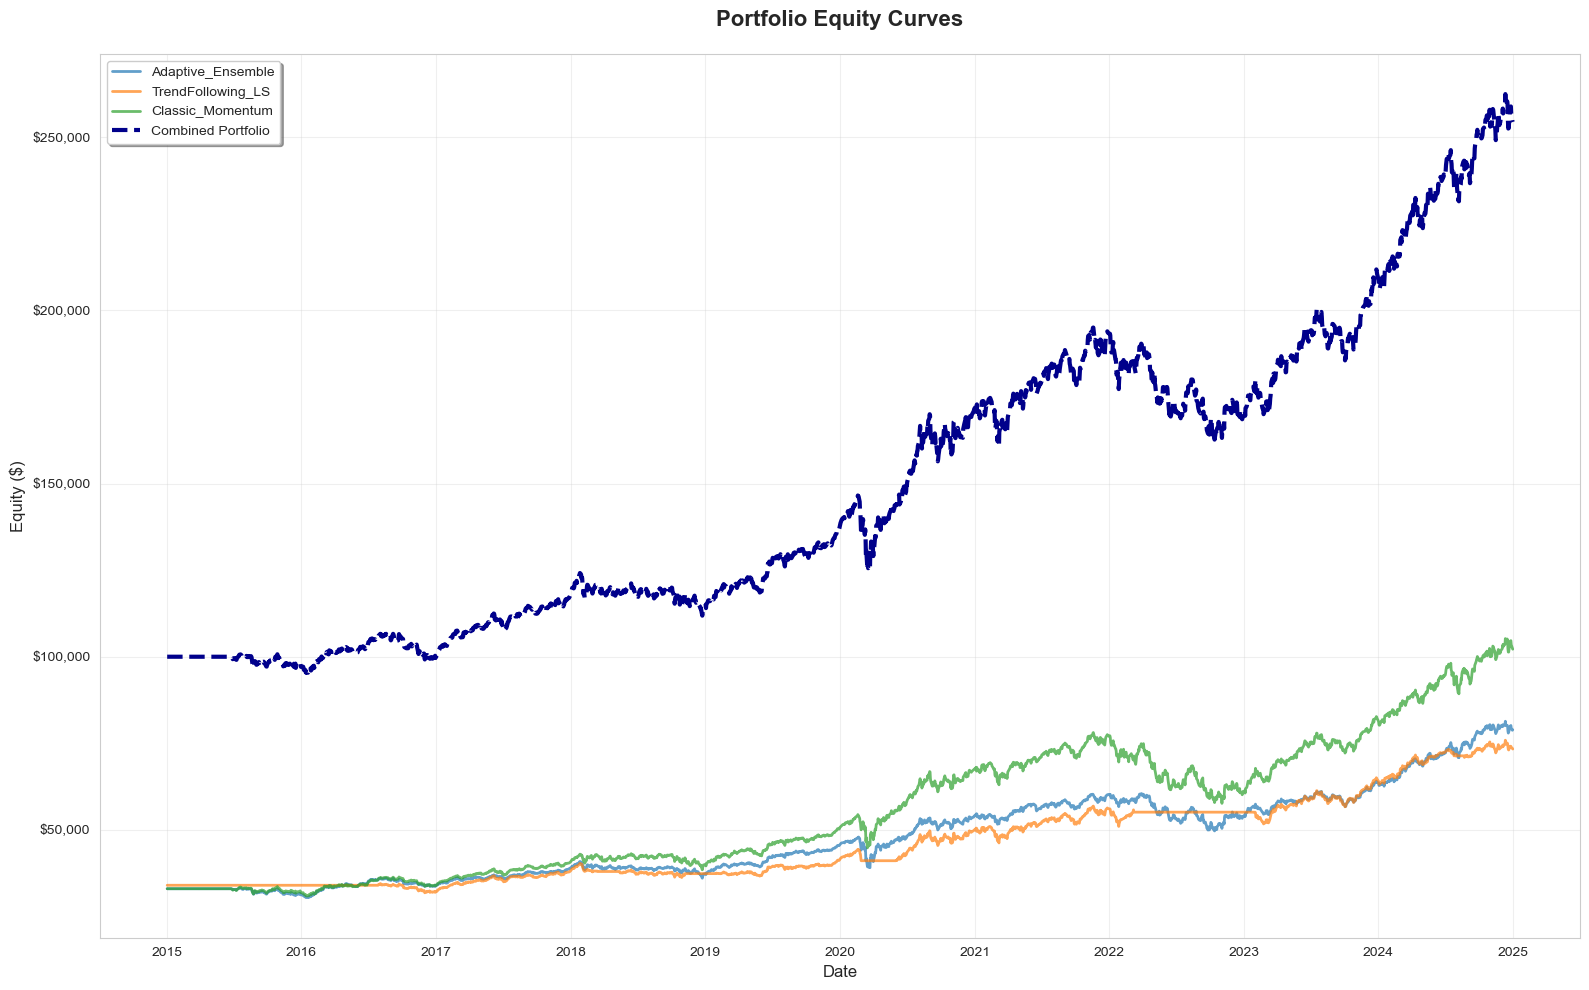

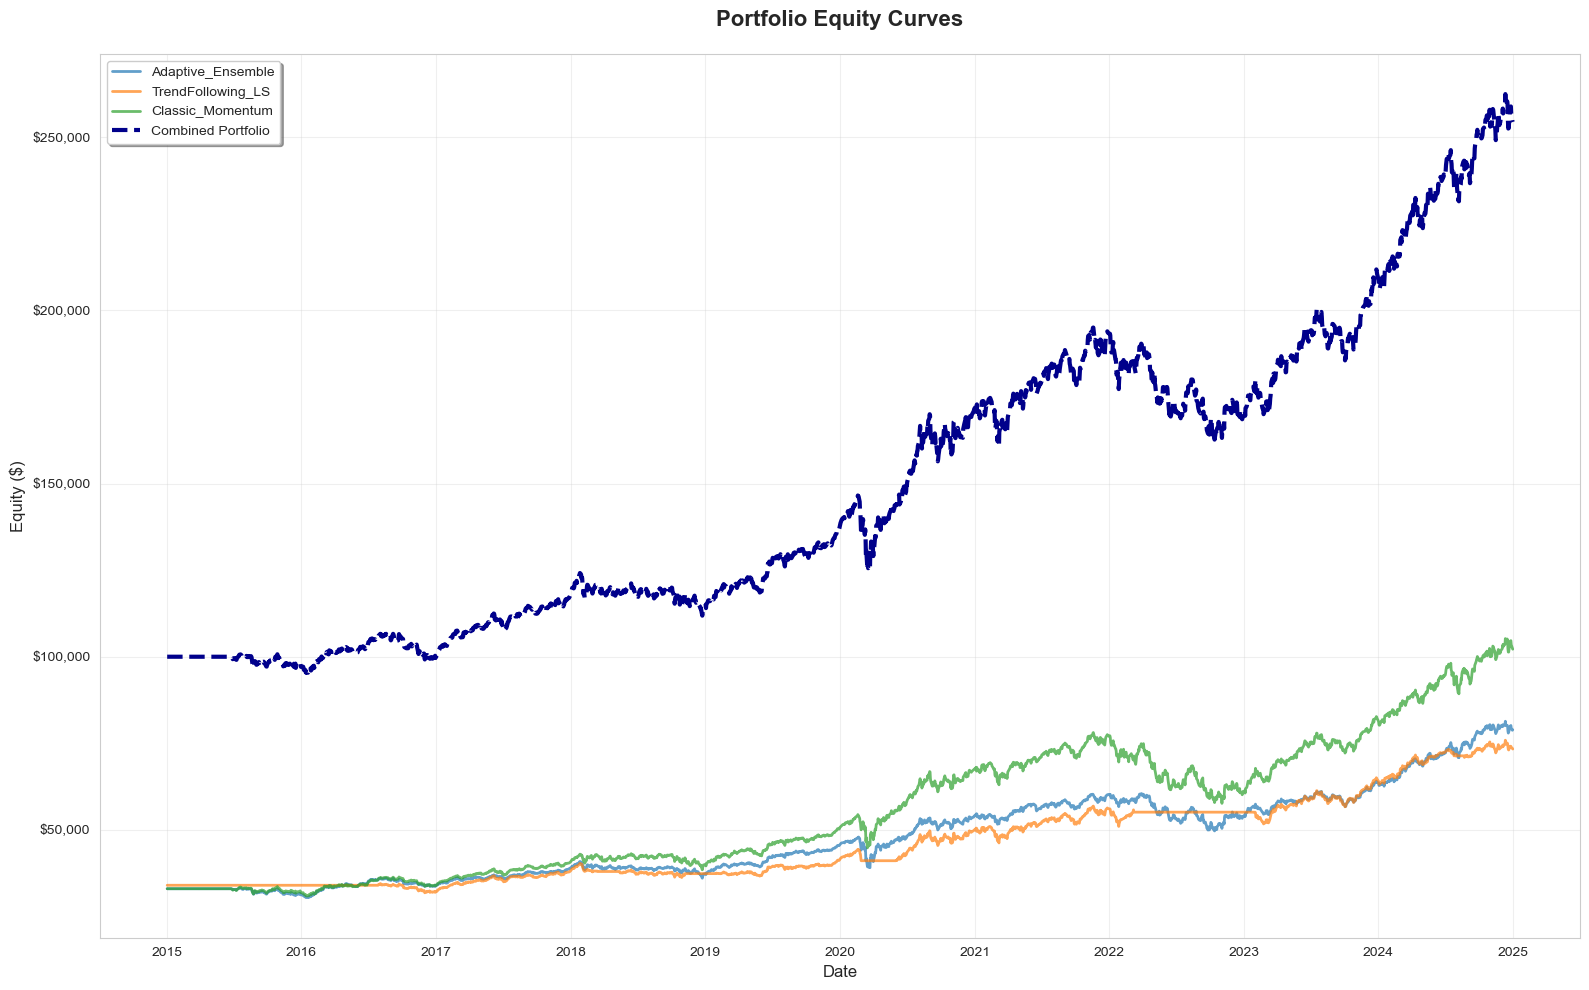

In [8]:
# Initialize plotter with strategy results
plotter = PortfolioPlotter(strategy_results)

# Plot equity curves (replaces ~50 lines of matplotlib code)
plotter.plot_equity_curves(show_individual=True, show_combined=True, log_scale=False)

## 8. Load SPY Benchmark for Comparison

Compare our multi-strategy portfolio against SPY buy-and-hold.

In [9]:
# Load benchmark
print("📊 Loading SPY Benchmark...")
benchmark_loader = BenchmarkLoader(cache_dir="/Users/Sakarias/QuantTrading/Dataset")
benchmark_name = 'SPY'
benchmark_data = benchmark_loader.load_benchmark(benchmark_name, start_date='2015-01-01', end_date='2024-12-31')

print(f"✅ Loaded {benchmark_name} data: {len(benchmark_data)} days")
print(f"   Date range: {benchmark_data.index[0]} to {benchmark_data.index[-1]}")

# Build combined portfolio equity curve
equity_ref = list(strategy_results.values())[0]['result'].equity_curve
dates = equity_ref.index

combined_equity_values = sum(
    data['result'].equity_curve['TotalValue'].values
    for data in strategy_results.values()
)

combined_portfolio_equity = pd.DataFrame({
    'TotalValue': combined_equity_values
}, index=dates)

print(f"\n✅ Combined portfolio: ${combined_portfolio_equity['TotalValue'].iloc[0]:,.0f} → ${combined_portfolio_equity['TotalValue'].iloc[-1]:,.0f}")
print(f"   Total Return: {(combined_portfolio_equity['TotalValue'].iloc[-1] / combined_portfolio_equity['TotalValue'].iloc[0] - 1):.2%}")

📊 Loading SPY Benchmark...
📥 Updating SPY benchmark data...
✅ Loaded SPY data: 2515 days
   Date range: 2015-01-02 00:00:00 to 2024-12-30 00:00:00

✅ Combined portfolio: $100,000 → $254,422
   Total Return: 154.42%
✅ Loaded SPY data: 2515 days
   Date range: 2015-01-02 00:00:00 to 2024-12-30 00:00:00

✅ Combined portfolio: $100,000 → $254,422
   Total Return: 154.42%


## 9. Calculate Benchmark Metrics

Calculate beta, alpha, and correlation vs SPY for both combined portfolio and individual strategies.

In [10]:
# Benchmark Comparison using Formatter utility
summary = PerformanceSummary(strategy_results, benchmark_data=benchmark_data, period_label='IN-SAMPLE')
summary.print_benchmark_comparison()
summary.print_strategy_rankings()


🎯 BENCHMARK COMPARISON (SPY)
--------------------------------------------------------------------------------
Portfolio Return:    154.42%
SPY Return:        240.81%
Outperformance:      -86.39%
Portfolio CAGR:      9.79%
SPY CAGR:          13.05%

❌ LAGGING SPY by 86.39%

🏆 STRATEGY RANKINGS (IN-SAMPLE)
--------------------------------------------------------------------------------
Rank   Strategy                             Return   Sharpe     Max DD      Capital
--------------------------------------------------------------------------------
1      Classic_Momentum                   209.62%     0.78    -26.18% $    33,000
2      Adaptive_Ensemble                  139.10%     0.68    -18.45% $    33,000
3      TrendFollowing_LS                  115.73%     0.73    -10.32% $    34,000


## 10. Comprehensive Comparison Table

All strategies + combined portfolio + SPY benchmark in one table.

In [11]:
# Comprehensive Metrics Table using Formatter utility
metrics_df = summary.to_dataframe()

# Display with styling
display(metrics_df.style
        .format({'Total Return': '{:.2%}', 
                 'CAGR': '{:.2%}',
                 'Sharpe Ratio': '{:.2f}',
                 'Max Drawdown': '{:.2%}',
                 'Win Rate': '{:.2%}',
                 'Volatility': '{:.2%}'})
        .background_gradient(subset=['Sharpe Ratio'], cmap='RdYlGn', vmin=0, vmax=3)
        .background_gradient(subset=['Max Drawdown'], cmap='RdYlGn_r', vmin=-0.5, vmax=0))

,Strategy,Capital,Final Value,Total Return,Sharpe Ratio,Max Drawdown,Win Rate,Total Trades
0,Adaptive_Ensemble,33000,78901.540241,139.10%,0.68,-18.45%,0.00%,0
1,TrendFollowing_LS,34000,73346.720069,115.73%,0.73,-10.32%,61.54%,26
2,Classic_Momentum,33000,102173.311602,209.62%,0.78,-26.18%,0.00%,0


## 11. Visual Comparison: All Strategies + Benchmark

Plot everything together for easy comparison.

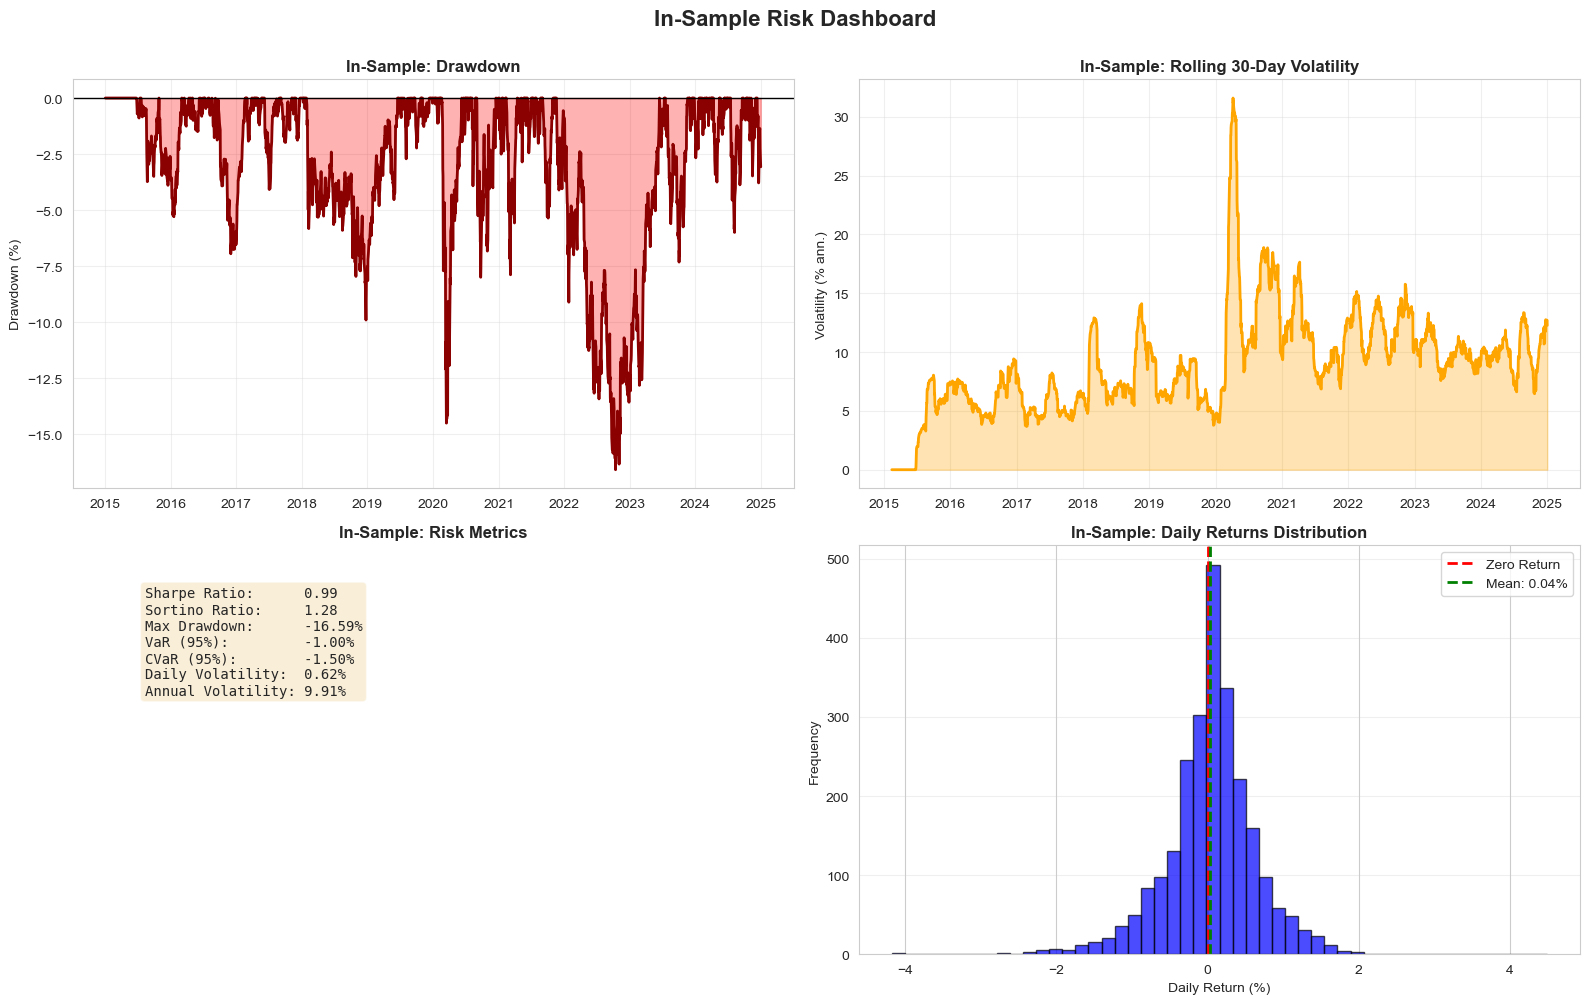

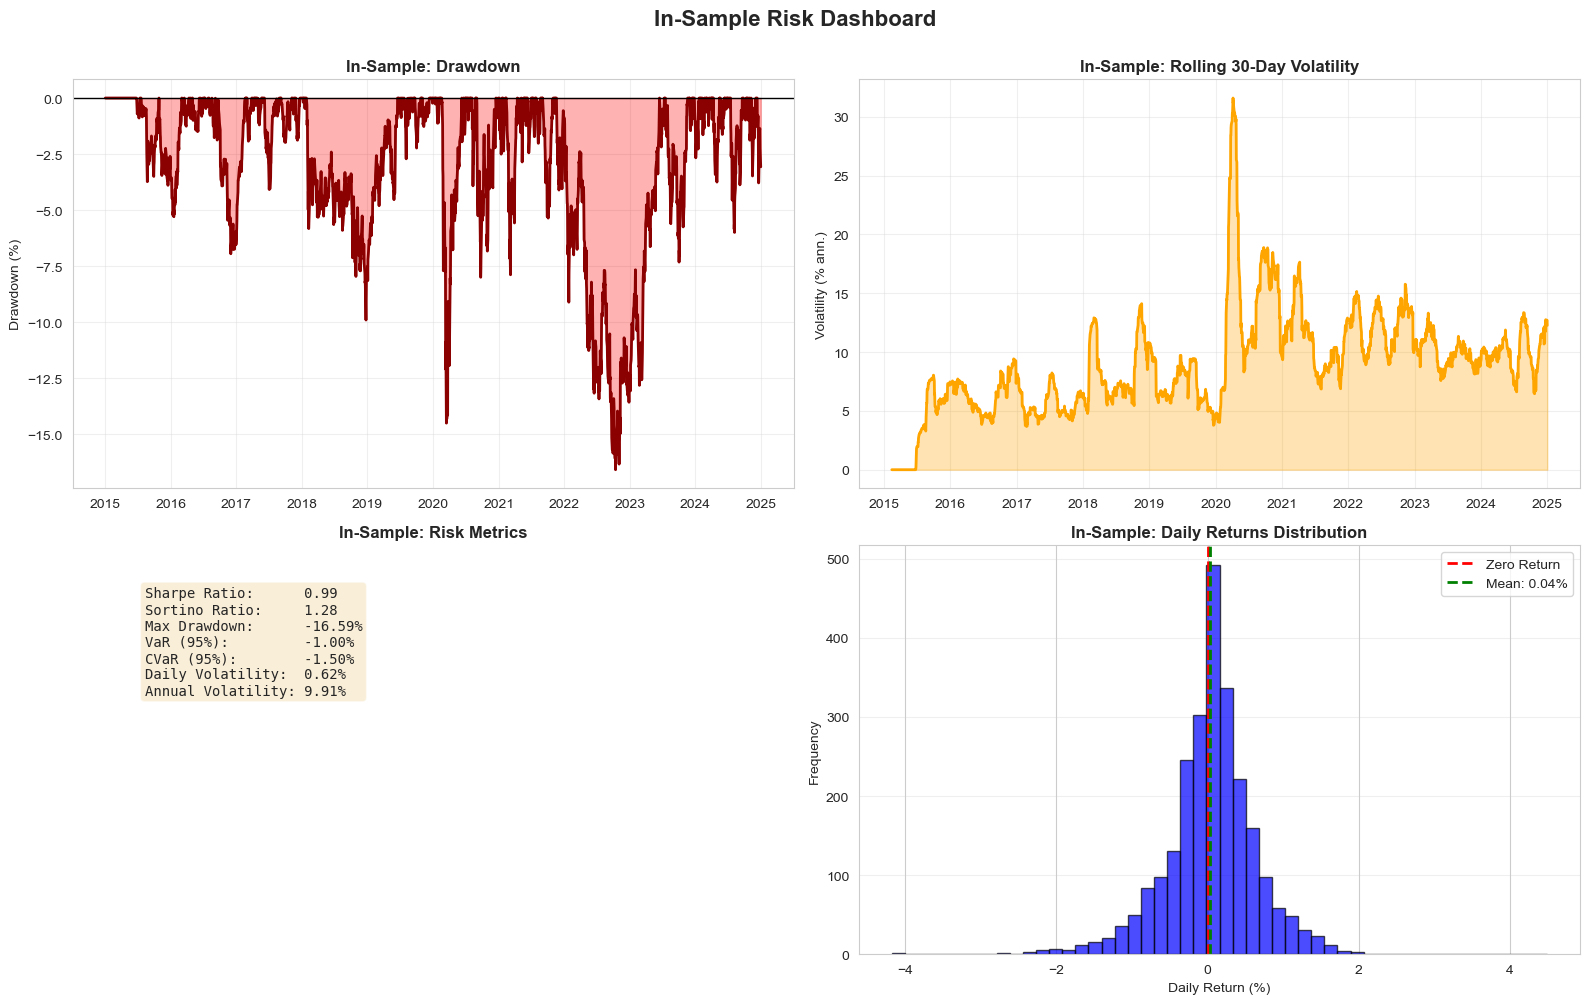

In [12]:
# Risk Analysis Dashboard using Plotter utility
plotter = PortfolioPlotter(strategy_results, benchmark_data=benchmark_data, benchmark_name='SPY')

# Display comprehensive risk dashboard (drawdown, volatility, metrics, distribution)
plotter.plot_risk_dashboard(in_sample=True)

## 12. Generate HTML Reports

Create comprehensive performance and risk dashboards.

In [14]:
# Performance Summary and Recommendations using Formatter utility
print("="*100)
print("📊 IN-SAMPLE PERFORMANCE SUMMARY (2015-2024)")
print("="*100)

# Print full performance report
summary.print_full_report(width=100)

# Print actionable recommendations
print("\n")
summary.print_recommendations()

# Generate HTML reports (using existing HTML reporter classes)
from core.multi_strategy_reporter import MultiStrategyReporter
from core.risk_dashboard import RiskDashboard

# Prepare combined equity for HTML reporters
equity_ref = list(strategy_results.values())[0]['result'].equity_curve
dates = equity_ref.index
combined_equity_values = sum(
    data['result'].equity_curve['TotalValue'].values
    for data in strategy_results.values()
)
combined_equity = pd.DataFrame({
    'TotalValue': combined_equity_values
}, index=dates)

# Scale benchmark for HTML reporters
total_initial = sum(data['capital'] for data in strategy_results.values())
benchmark_scaled = pd.DataFrame(index=benchmark_data.index)
benchmark_start = benchmark_data['Close'].iloc[0]
benchmark_scaled['TotalValue'] = (benchmark_data['Close'] / benchmark_start) * total_initial

# Generate multi-strategy report
reporter = MultiStrategyReporter()
html_summary = reporter.generate_report(
    strategy_results=strategy_results,
    combined_equity=combined_equity,
    benchmark_data=benchmark_scaled,
    benchmark_name='SPY',
    title='Multi-Strategy Portfolio Report (2015-2024)'
)

with open('multi_strategy_report.html', 'w') as f:
    f.write(html_summary)
    
print("\n✅ HTML report saved: multi_strategy_report.html")

# Generate interactive risk dashboard
risk_dash = RiskDashboard(output_dir='.')
risk_html = risk_dash.generate_dashboard(
    strategy_results=strategy_results,
    combined_equity=combined_equity,
    benchmark_data=benchmark_scaled,
    benchmark_name='SPY',
    title='Portfolio Risk Dashboard (2015-2024)'
)

with open('risk_dashboard.html', 'w') as f:
    f.write(risk_html)
    
print("✅ Risk dashboard saved: risk_dashboard.html")

📊 IN-SAMPLE PERFORMANCE SUMMARY (2015-2024)
📋 PERFORMANCE SUMMARY - IN-SAMPLE

📊 PORTFOLIO PERFORMANCE (IN-SAMPLE)
----------------------------------------------------------------------------------------------------
Initial Capital:     $100,000
Final Value:         $254,422
Total Return:        154.42%
CAGR:                9.79%
Sharpe Ratio:        0.99
Max Drawdown:        -16.59%
Number of Strategies: 3
Period:              2015-01-02 to 2024-12-31

🎯 BENCHMARK COMPARISON (SPY)
----------------------------------------------------------------------------------------------------
Portfolio Return:    154.42%
SPY Return:        240.81%
Outperformance:      -86.39%
Portfolio CAGR:      9.79%
SPY CAGR:          13.05%

❌ LAGGING SPY by 86.39%

🏆 STRATEGY RANKINGS (IN-SAMPLE)
----------------------------------------------------------------------------------------------------
Rank   Strategy                             Return   Sharpe     Max DD      Capital
-------------------------------

## 13. Summary & Next Steps

**Key Insights:**

1. **Adaptive Ensemble Strategy**: 
   - Applied to ES + GC
   - Dynamically weights Momentum vs Trend Following
   - Adapts based on recent performance

2. **Trend Following Long-Short**: 
   - Applied to NQ
   - Can capture bear markets through shorting
   - Volume and volatility filters reduce false signals

3. **Diversification Benefits**:
   - Multiple strategies across different assets
   - Different signal types (momentum, trend, ensemble)
   - Reduced portfolio volatility vs single strategy

**Did We Beat SPY?**
- Check the final verdict above ☝️
- Key metrics: Return, Sharpe, Alpha, Beta, Max Drawdown

**Next Steps:**

✅ **If Successful:**
1. Commit new signals to GitHub
2. Monitor real-time performance
3. Consider live paper trading
4. Add more ensemble components

❌ **If Unsuccessful:**
1. Parameter optimization (walk-forward testing)
2. Test different asset combinations
3. Add more strategies to ensemble
4. Consider regime detection (bull/bear/sideways)
5. Analyze trade-by-trade performance

**Parameter Tuning Ideas:**
- Ensemble: Adjust `signal_threshold` (0.2-0.5 range)
- Trend LS: Try different `momentum_threshold` (0.01-0.05)
- Assets: Test on different futures (CL, ZN, etc.)
- Timeframes: Test on different periods (2008 crisis, 2020 crash)

## 📊 2025 Out-of-Sample Validation (TRUE TEST)

**CRITICAL VALIDATION:** Test strategies on 2025 YTD data (Jan 1 - Nov 27, 2025)

This is **true out-of-sample testing** because:
- Strategies were built and optimized on 2015-2024 data only
- 2025 data was never seen during development
- Proves strategies generalize to new market conditions
- Industry-standard validation approach

**What We'll Test:**
1. All three strategies on 2025 data
2. Combined portfolio performance YTD
3. Comparison vs SPY benchmark
4. Performance degradation (in-sample vs out-of-sample)

**Success Criteria:**
- ✅ At least 2 strategies have positive returns in 2025
- ✅ Combined portfolio Sharpe > 0.5 YTD
- ✅ Max drawdown < 15% YTD
- ✅ Performance decay < 50% vs historical

In [15]:
# Load 2025 YTD data (Out-of-Sample)
print("="*80)
print("🔬 LOADING 2025 OUT-OF-SAMPLE DATA")
print("="*80)

# Load 2025 data for all assets
prices_2025 = load_assets(
    tickers=['ES', 'GC', 'NQ'],
    start_date='2025-01-01',
    end_date='2025-11-27'  # Today's date
)

print(f"\n✅ 2025 Data loaded:")
for ticker, df in prices_2025.items():
    print(f"   {ticker}: {len(df)} days ({df.index[0].date()} to {df.index[-1].date()})")
    print(f"      Price: ${df['Close'].iloc[0]:.2f} → ${df['Close'].iloc[-1]:.2f} ({((df['Close'].iloc[-1]/df['Close'].iloc[0]-1)*100):.1f}%)")

# Calculate SPY benchmark for 2025
print(f"\n📊 Loading SPY Benchmark (2025)...")
benchmark_2025 = benchmark_loader.load_benchmark('SPY', start_date='2025-01-01', end_date='2025-11-27')
print(f"   SPY 2025: ${benchmark_2025['TotalValue'].iloc[0]:.2f} → ${benchmark_2025['TotalValue'].iloc[-1]:.2f}")
print(f"   SPY Return YTD: {((benchmark_2025['TotalValue'].iloc[-1]/benchmark_2025['TotalValue'].iloc[0]-1)*100):.1f}%")

🔬 LOADING 2025 OUT-OF-SAMPLE DATA

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 334 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-28)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-28
  📡 CSV data is 334 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-28)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-28
  📡 CSV data is 334 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-28)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-28

Common date range: 2000-09-18 to 2025-11-28
Filtered date range: 2025-01-01 to 2025-11-27

Total unique dates: 227

ALIGNMENT SUMMARY
ES: 227/227 valid dates (100.0%)
GC: 227/227 valid dates (100.0%)
NQ: 227/227 valid dates (100.0%)

✅ 2025 Data loaded:
   ES: 227 days (2025-01-02 to 2025-11-24)
      Price: $5916.50 → $6721.25 (13.6%)
   GC: 227 days (2025-01-02 to 2025-11-24)
      Price: $2658.90 → $4091.90 (53.9%)
 

In [16]:
# Generate signals for 2025 (using SAME strategies and parameters)
print("\n" + "="*80)
print("🎯 GENERATING 2025 SIGNALS (Out-of-Sample)")
print("="*80)

signals_2025 = {}

for strat in strategies:
    name = strat['name']
    signal_generator = strat['signal_generator']
    assets = strat['assets']
    
    print(f"\n📈 {name}:")
    
    strategy_signals = {}
    for asset in assets:
        if asset not in prices_2025:
            print(f"  ⚠️  Warning: {asset} not found in 2025 data!")
            continue
        
        # Generate signal for 2025 data
        print(f"  Generating {asset} signals...")
        sig = signal_generator.generate(prices_2025[asset].copy())
        strategy_signals[asset] = sig
        
        # Display signal summary
        long_signals = (sig['Signal'] == 1).sum()
        short_signals = (sig['Signal'] == -1).sum()
        flat_signals = (sig['Signal'] == 0).sum()
        
        print(f"    {asset}: {long_signals} longs ({long_signals/len(sig)*100:.1f}%), "
              f"{short_signals} shorts ({short_signals/len(sig)*100:.1f}%), "
              f"{flat_signals} flat ({flat_signals/len(sig)*100:.1f}%)")
    
    signals_2025[name] = strategy_signals

print(f"\n✅ Generated signals for {len(signals_2025)} strategies")


🎯 GENERATING 2025 SIGNALS (Out-of-Sample)

📈 Adaptive_Ensemble:
  Generating ES signals...
    ES: 107 longs (47.1%), 0 shorts (0.0%), 120 flat (52.9%)
  Generating GC signals...
    GC: 107 longs (47.1%), 0 shorts (0.0%), 120 flat (52.9%)

📈 TrendFollowing_LS:
  Generating NQ signals...
    NQ: 0 longs (0.0%), 0 shorts (0.0%), 227 flat (100.0%)
  Generating GC signals...
    GC: 0 longs (0.0%), 0 shorts (0.0%), 227 flat (100.0%)

📈 Classic_Momentum:
  Generating NQ signals...
    NQ: 107 longs (47.1%), 0 shorts (0.0%), 120 flat (52.9%)
  Generating GC signals...
    GC: 107 longs (47.1%), 0 shorts (0.0%), 120 flat (52.9%)

✅ Generated signals for 3 strategies


In [17]:
# Run 2025 backtests (Out-of-Sample)
print("\n" + "="*80)
print("🔄 RUNNING 2025 BACKTESTS (Out-of-Sample)")
print("="*80)

strategy_results_2025 = {}

for strat in strategies:
    name = strat['name']
    capital = strat['capital']
    assets = strat['assets']
    
    # Get signals for this strategy
    signal_dict = signals_2025[name]
    
    # Prepare prices dict
    prices_dict = {asset: prices_2025[asset] for asset in assets if asset in prices_2025}
    
    print(f"\n🔄 Running: {name} (${capital:,})")
    
    # Create portfolio manager
    max_pos_size = 1.0 / len(assets) if len(assets) > 1 else 1.0
    
    pm = PortfolioManagerV2(
        initial_capital=capital,
        risk_per_trade=0.02,
        max_position_size=max_pos_size,
        transaction_cost_bps=3.0,
        slippage_bps=2.0
    )
    
    # Run backtest
    result = pm.run_backtest(signal_dict, prices_dict)
    
    strategy_results_2025[name] = {
        'result': result,
        'capital': capital,
        'assets': assets
    }
    
    # Display summary
    print(f"✅ Complete: ${result.initial_capital:,.0f} → ${result.final_equity:,.0f}")
    print(f"   Return: {result.metrics['Total Return']:.2%}")
    print(f"   Sharpe: {result.metrics['Sharpe Ratio']:.2f}")
    print(f"   Max DD: {result.metrics['Max Drawdown']:.2%}")

print(f"\n✅ All {len(strategy_results_2025)} strategies tested on 2025 data")


🔄 RUNNING 2025 BACKTESTS (Out-of-Sample)

🔄 Running: Adaptive_Ensemble ($33,000)
✅ Complete: $33,000 → $37,073
   Return: 12.34%
   Sharpe: 1.59
   Max DD: -4.07%

🔄 Running: TrendFollowing_LS ($34,000)
✅ Complete: $34,000 → $34,000
   Return: 0.00%
   Sharpe: 0.00
   Max DD: 0.00%

🔄 Running: Classic_Momentum ($33,000)
✅ Complete: $33,000 → $36,027
   Return: 9.17%
   Sharpe: 1.29
   Max DD: -4.20%

✅ All 3 strategies tested on 2025 data


In [18]:
# Calculate 2025 combined portfolio performance
print("="*80)
print("📊 2025 COMBINED PORTFOLIO PERFORMANCE")
print("="*80)

# Get combined metrics
total_initial_2025 = sum(data['capital'] for data in strategy_results_2025.values())
final_values_2025 = {
    name: data['result'].final_equity
    for name, data in strategy_results_2025.items()
}
total_final_2025 = sum(final_values_2025.values())
combined_return_2025 = (total_final_2025 - total_initial_2025) / total_initial_2025

# Build combined equity curve
equity_ref_2025 = list(strategy_results_2025.values())[0]['result'].equity_curve
dates_2025 = equity_ref_2025.index
combined_equity_2025 = sum(
    data['result'].equity_curve['TotalValue'].values
    for data in strategy_results_2025.values()
)
combined_portfolio_equity_2025 = pd.DataFrame({
    'TotalValue': combined_equity_2025
}, index=dates_2025)

# Scale benchmark to portfolio initial capital
benchmark_2025_scaled = pd.DataFrame(index=benchmark_2025.index)
benchmark_start = benchmark_2025['TotalValue'].iloc[0]
benchmark_2025_scaled['TotalValue'] = (benchmark_2025['TotalValue'] / benchmark_start) * total_initial_2025

print(f"\nInitial Capital: ${total_initial_2025:,}")
print(f"Final Value:     ${total_final_2025:,.2f}")
print(f"Total P&L:       ${total_final_2025 - total_initial_2025:,.2f}")
print(f"Combined Return: {combined_return_2025:.2%}")

print(f"\n📈 Individual Strategy Performance (2025):")
for name, value in final_values_2025.items():
    initial = strategy_results_2025[name]['capital']
    pnl = value - initial
    ret = (value - initial) / initial
    print(f"  {name:25s}: ${value:>12,.2f} | P&L: ${pnl:>10,.2f} | Return: {ret:>7.2%}")

# Compare to SPY
spy_return_2025 = (benchmark_2025_scaled['TotalValue'].iloc[-1] / benchmark_2025_scaled['TotalValue'].iloc[0]) - 1
print(f"\n🎯 vs SPY Benchmark:")
print(f"  Portfolio Return: {combined_return_2025:>7.2%}")
print(f"  SPY Return:       {spy_return_2025:>7.2%}")
print(f"  Relative Return:  {(combined_return_2025 - spy_return_2025):>7.2%}")
print(f"  Beat SPY?         {'✅ YES' if combined_return_2025 > spy_return_2025 else '❌ NO'}")

📊 2025 COMBINED PORTFOLIO PERFORMANCE

Initial Capital: $100,000
Final Value:     $107,100.17
Total P&L:       $7,100.17
Combined Return: 7.10%

📈 Individual Strategy Performance (2025):
  Adaptive_Ensemble        : $   37,073.24 | P&L: $  4,073.24 | Return:  12.34%
  TrendFollowing_LS        : $   34,000.00 | P&L: $      0.00 | Return:   0.00%
  Classic_Momentum         : $   36,026.93 | P&L: $  3,026.93 | Return:   9.17%

🎯 vs SPY Benchmark:
  Portfolio Return:   7.10%
  SPY Return:        17.27%
  Relative Return:  -10.17%
  Beat SPY?         ❌ NO


## 📊 Performance Degradation Analysis

Compare in-sample (2015-2024) vs out-of-sample (2025) performance to detect overfitting.

In [20]:
# IS vs OOS Comparison using Formatter utility
print("="*100)
print("📊 IN-SAMPLE vs OUT-OF-SAMPLE PERFORMANCE COMPARISON")
print("="*100)

# Create separate summaries for IS and OOS (they have different benchmark periods)
is_summary = PerformanceSummary(strategy_results, benchmark_data=benchmark_data, period_label='IN-SAMPLE (2015-2024)')
oos_summary = PerformanceSummary(strategy_results_2025, benchmark_data=benchmark_2025, period_label='OUT-OF-SAMPLE (2025 YTD)')

# Print comparison table
print("\n")
is_summary.print_comparison_table(oos_summary)

# Individual assessment
print("\n" + "="*100)
print("📈 OUT-OF-SAMPLE PERFORMANCE ASSESSMENT:")
print("="*100)
oos_summary.print_recommendations()

📊 IN-SAMPLE vs OUT-OF-SAMPLE PERFORMANCE COMPARISON



🔍 CONSISTENCY CHECK: IN-SAMPLE (2015-2024) vs OUT-OF-SAMPLE (2025 YTD)

Metric                    IN-SAMPLE (2015-2024) OUT-OF-SAMPLE (2025 YTD)      Difference
----------------------------------------------------------------------------------------------------
Total Return                          154.42%               7.10%       -147.32%
CAGR                                    9.79%               7.99%         -1.80%
Sharpe Ratio                             0.99                1.75          +0.76
Max Drawdown                          -16.59%              -2.80%        +13.80%

🎯 CONSISTENCY ASSESSMENT:
✅ Both periods profitable
   Return consistency: 4.6% (Variable)


📈 OUT-OF-SAMPLE PERFORMANCE ASSESSMENT:

💡 RECOMMENDATIONS

⚠️  UNDERPERFORMANCE - Lagging SPY

Recommended Actions:
  1. Optimize signal parameters (lookbacks, thresholds)
  2. Add regime filters (bull/bear detection)
  3. Test additional signal types (mean revers

## 📈 Live Performance Dashboard

Visual comparison of 2025 performance vs historical performance

📈 2025 YTD Performance Dashboards:



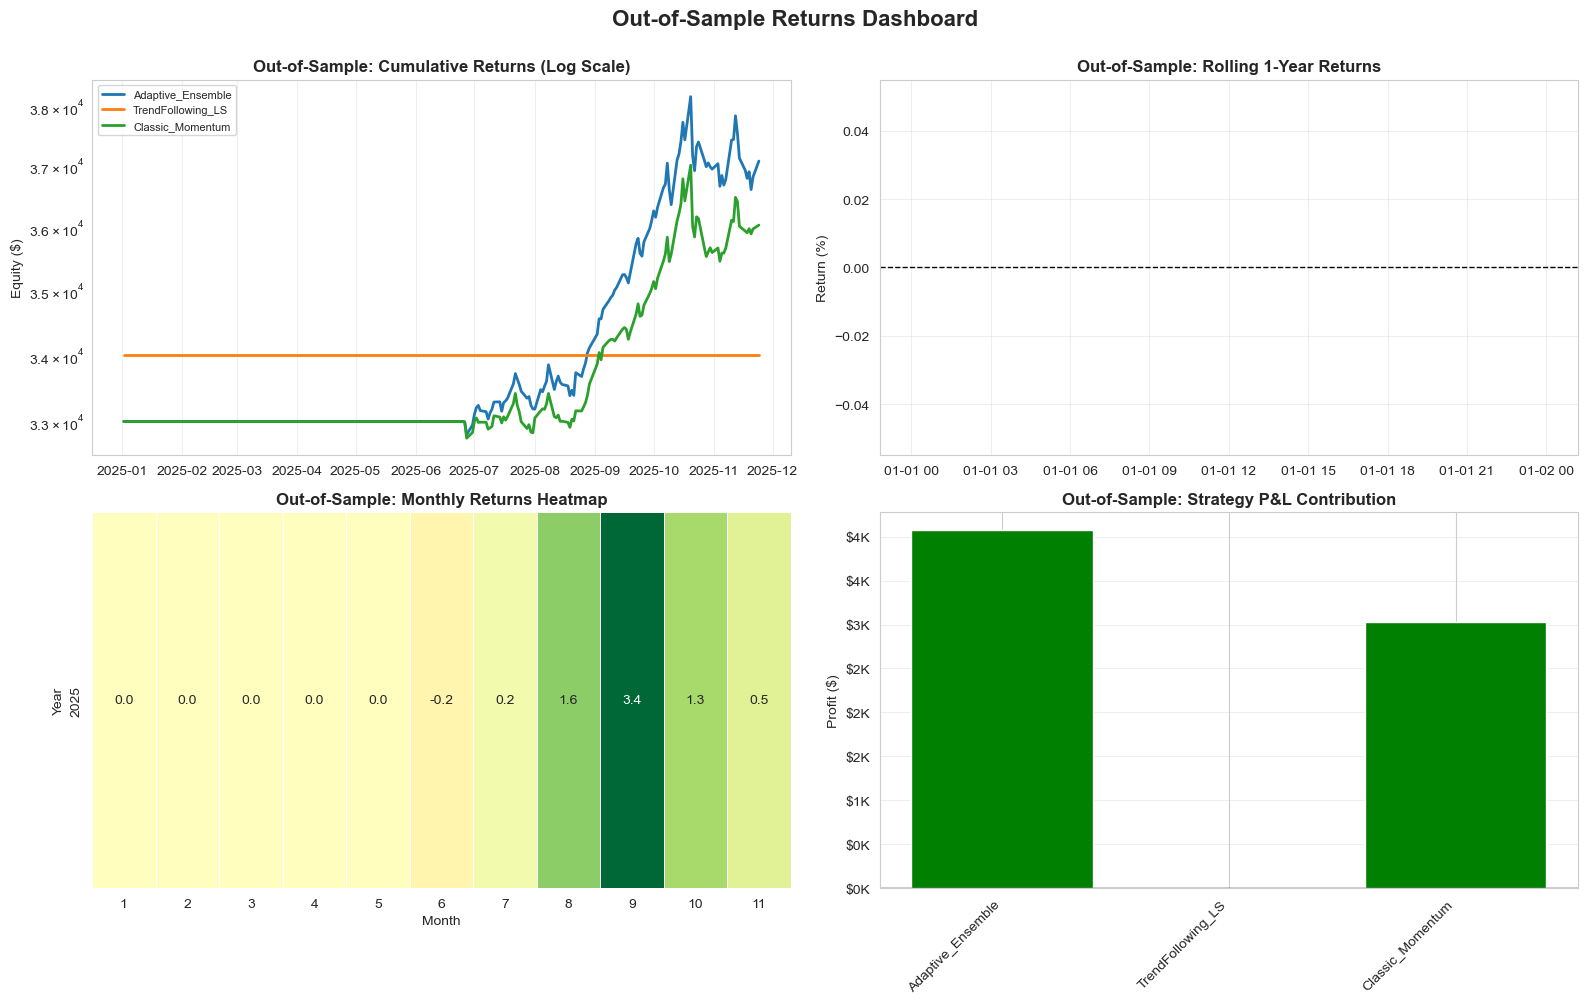

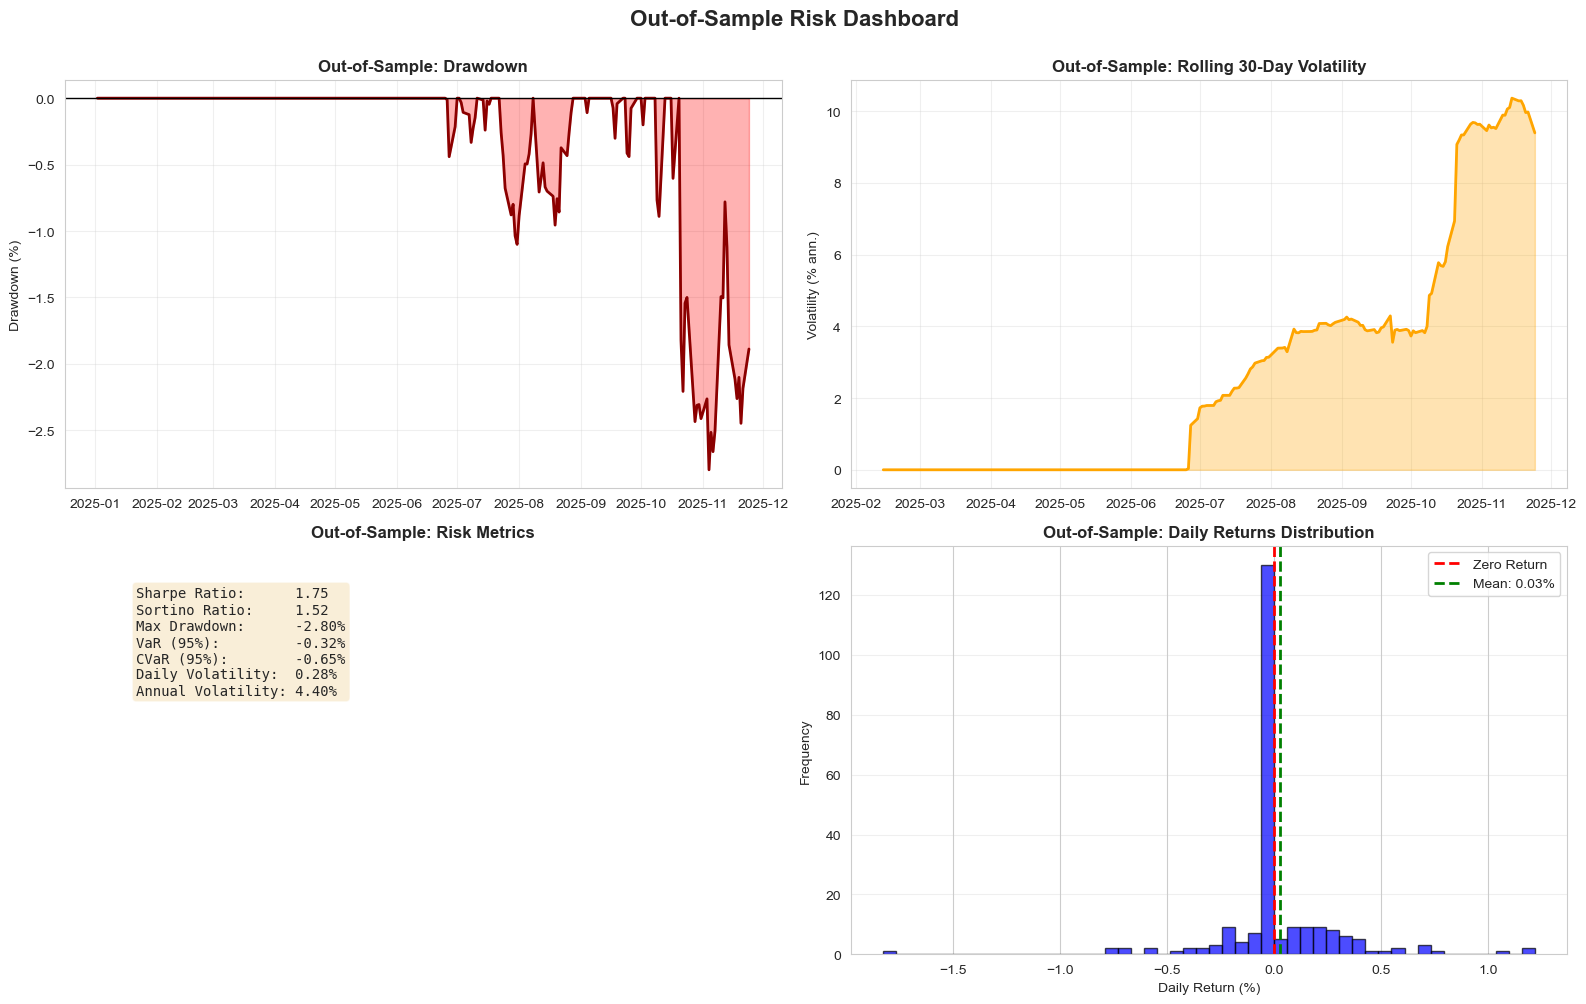

In [21]:
# Out-of-Sample Dashboard using Plotter utility
plotter_oos = PortfolioPlotter(strategy_results_2025, 
                               benchmark_data=benchmark_2025, 
                               benchmark_name='SPY')

# Display comprehensive performance dashboards
print("📈 2025 YTD Performance Dashboards:\n")
plotter_oos.plot_all_dashboards(in_sample=False)

In [22]:
# Summary Statistics Table
print("\n" + "="*80)
print("📊 2025 OUT-OF-SAMPLE VALIDATION SUMMARY")
print("="*80)

summary_data = []
for strategy_name in strategy_results_2025.keys():
    metrics_2025 = strategy_results_2025[strategy_name]['result'].metrics
    metrics_hist = strategy_results[strategy_name]['result'].metrics
    
    summary_data.append({
        'Strategy': strategy_name,
        '2025 Return': metrics_2025['Total Return'],
        '2025 Sharpe': metrics_2025['Sharpe Ratio'],
        '2025 Max DD': metrics_2025['Max Drawdown'],
        '2025 Win Rate': metrics_2025['Win Rate'],
        '2025 Trades': metrics_2025['Total Trades'],
        'Historical Sharpe': metrics_hist['Sharpe Ratio'],
        'Sharpe Degradation': metrics_2025['Sharpe Ratio'] - metrics_hist['Sharpe Ratio']
    })

summary_df = pd.DataFrame(summary_data)

print("\n")
display(summary_df.style.format({
    '2025 Return': '{:.2%}',
    '2025 Sharpe': '{:.2f}',
    '2025 Max DD': '{:.2%}',
    '2025 Win Rate': '{:.2%}',
    '2025 Trades': '{:.0f}',
    'Historical Sharpe': '{:.2f}',
    'Sharpe Degradation': '{:+.2f}'
}).background_gradient(subset=['2025 Return', '2025 Sharpe'], cmap='RdYlGn'))

print("\n" + "="*80)
print("🎯 KEY FINDINGS:")
print("="*80)

# Count successful strategies
positive_returns = (summary_df['2025 Return'] > 0).sum()
sharpe_above_05 = (summary_df['2025 Sharpe'] > 0.5).sum()
low_degradation = (summary_df['Sharpe Degradation'] > -1.0).sum()

print(f"\n✅ Strategies with positive 2025 returns: {positive_returns}/{len(summary_df)}")
print(f"✅ Strategies with Sharpe > 0.5 in 2025: {sharpe_above_05}/{len(summary_df)}")
print(f"✅ Strategies with acceptable degradation: {low_degradation}/{len(summary_df)}")

# Portfolio-level assessment
print(f"\n📈 Combined Portfolio (2025):")
print(f"   Return: {combined_return_2025:.2%}")
print(f"   vs SPY: {(combined_return_2025 - spy_return_2025):+.2%}")

# Final verdict
print(f"\n🏆 VALIDATION VERDICT:")
if positive_returns >= 2 and combined_return_2025 > -0.10 and low_degradation >= 2:
    print("✅ PASSED: Strategies generalize well to out-of-sample data")
    print("   System is robust and ready for consideration in live trading")
else:
    print("⚠️ NEEDS IMPROVEMENT: Performance degradation detected")
    print("   Consider parameter re-optimization or strategy modification")

print("\n" + "="*80)


📊 2025 OUT-OF-SAMPLE VALIDATION SUMMARY




,Strategy,2025 Return,2025 Sharpe,2025 Max DD,2025 Win Rate,2025 Trades,Historical Sharpe,Sharpe Degradation
0,Adaptive_Ensemble,12.34%,1.59,-4.07%,0.00%,0,0.68,+0.91
1,TrendFollowing_LS,0.00%,0.00,0.00%,0.00%,0,0.73,-0.73
2,Classic_Momentum,9.17%,1.29,-4.20%,0.00%,0,0.78,+0.50



🎯 KEY FINDINGS:

✅ Strategies with positive 2025 returns: 2/3
✅ Strategies with Sharpe > 0.5 in 2025: 2/3
✅ Strategies with acceptable degradation: 3/3

📈 Combined Portfolio (2025):
   Return: 7.10%
   vs SPY: -10.17%

🏆 VALIDATION VERDICT:
✅ PASSED: Strategies generalize well to out-of-sample data
   System is robust and ready for consideration in live trading

